In [1]:
import torch
from PIL import Image

from src.model import SiamNet, get_siamnet
from src.model import EfficientNetB3Encoder, CLIPEncoder, ViTEncoder
from src.dataset import get_augmentations, load_config, get_coco_dataloaders, CocoDataset
from src.train import train_model

%load_ext autoreload
%autoreload 2

/home/jovyan/.mlspace/envs/genimages/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Augmentations

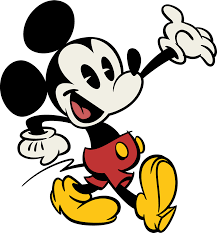

In [3]:
image = Image.open('assets/image.png').convert('RGB')
image

In [4]:
simple_transform, train_transform = get_augmentations()

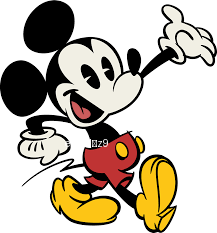

In [7]:
simple_aug = simple_transform(image)
simple_aug

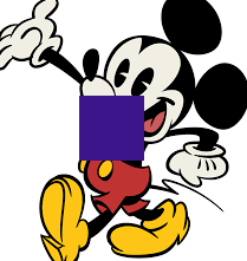

In [6]:
train_aug = train_transform(image)
train_aug

### Model

In [7]:
encoder = EfficientNetB3Encoder(freeze=True)
preprocess = encoder.preprocess

tensor = preprocess(image).unsqueeze(0)
print(tensor.shape, encoder(tensor).shape)

Loaded pretrained weights for efficientnet-b3
torch.Size([1, 3, 224, 224]) torch.Size([1, 1536])


In [7]:
encoder = CLIPEncoder(freeze=True)
preprocess = encoder.preprocess

tensor = preprocess(image).unsqueeze(0)
print(tensor.shape, encoder(tensor).shape)

torch.Size([1, 3, 224, 224]) torch.Size([1, 1024])


In [6]:
encoder = ViTEncoder(freeze=True)
preprocess = encoder.preprocess

tensor = preprocess(image).unsqueeze(0)
print(tensor.shape, encoder(tensor).shape)

torch.Size([1, 3, 224, 224]) torch.Size([1, 1024])


In [4]:
config = load_config('configs/train_config.yaml')
net = get_siamnet(config).to('cpu')
net(tensor, tensor)

tensor([[0.4655]], grad_fn=<ViewBackward0>)

### Data

In [14]:
path = '/home/jovyan/nkiselev/ddorin/project/Pairwise-Image-Matching/data'

config_path = "configs/train_config.yaml"
train_config = load_config(config_path)

net = get_siamnet(train_config).to('cpu')
preprocessor = net.get_preprocessing()

data = CocoDataset(path, preprocessor)

Loaded pretrained weights for efficientnet-b3


In [13]:
len(data)

258624

In [14]:
dataloaders = get_coco_dataloaders(path, 
                         preprocessor, 
                         batch_size=32, 
                         num_workers=4,
                         val_size=0.1, 
                         random_seed=42)

### Testing Model

In [174]:
checkpoint_path = 'checkpoint_dir/effnet_15ep_unfreeze/checkpoint_epoch_13.pth'

config_path = "configs/train_config.yaml"
train_config = load_config(config_path)

net = get_siamnet(train_config)
preprocessor = net.get_preprocessing()

Loaded pretrained weights for efficientnet-b3


In [182]:
checkpoint = torch.load(checkpoint_path, map_location='cpu')
net.load_state_dict(checkpoint['model_state_dict'])
net.to('cpu')
net.eval()
print('ready')

ready


In [190]:
tensor_aug_2 = preprocessor(image_aug_2.convert('RGB')).unsqueeze(0)
tensor_aug_1 = preprocessor(image_aug_1.convert('RGB')).unsqueeze(0)

In [86]:
duplicate_added_text = preprocessor(Image.open('assets/cats/duplicate-added-text.jpg')).unsqueeze(0)
duplicate_changed_colors = preprocessor(Image.open('assets/cats/duplicate-changed-colors.jpg')).unsqueeze(0)
duplicate_edited = preprocessor(Image.open('assets/cats/duplicate-edited.jpg')).unsqueeze(0)
duplicate_pixelated = preprocessor(Image.open('assets/cats/duplicate-pixelated.jpg')).unsqueeze(0)
duplicate_rotated = preprocessor(Image.open('assets/cats/duplicate-rotated.png').convert('RGB')).unsqueeze(0)
duplicate_stretched = preprocessor(Image.open('assets/cats/duplicate-stretched.png').convert('RGB')).unsqueeze(0)

In [141]:
image_1 = preprocessor(Image.open('assets/bio/image_1.jpg')).unsqueeze(0)
image_2 = preprocessor(Image.open('assets/bio/image_2.jpg')).unsqueeze(0)
image_3 = preprocessor(Image.open('assets/bio/image_3.jpg')).unsqueeze(0)
image_4 = preprocessor(Image.open('assets/bio/image_4.jpg')).unsqueeze(0)
image_stone = preprocessor(Image.open('assets/image_stone.jpg')).unsqueeze(0)

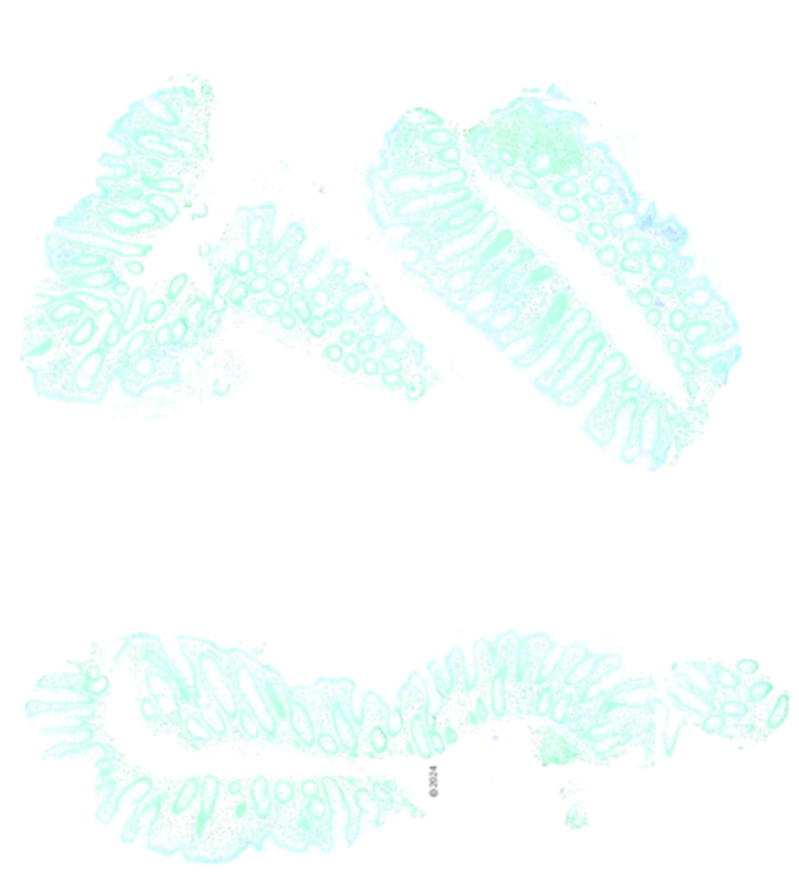

In [139]:
image_4_aug = train_transform(Image.open('assets/bio/image_4.jpg')).convert('RGB')
image_4_aug.show()
image_4_aug = preprocessor(image_4_aug).unsqueeze(0)

In [191]:
net(tensor_aug_2, tensor_aug_1).detach().numpy()

array([[9.308522e-15]], dtype=float32)